In [1]:
#!/usr/bin/env python3
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import pyhf
from scipy.interpolate import interp1d
import sys
sys.path.append('../')
from helper import varDict,getTitleFromDF

try:
    import mplhep as hep
    hep.style.use("ATLAS")
except:
    pass

### Get B2TF effs

In [2]:
b2tf_effs = np.genfromtxt('../B2TF-Trigger/b2tf_trigger_effs_jets_v2.csv',delimiter=',',names=True)
b2tf_data_df = pd.DataFrame(b2tf_effs,columns=b2tf_effs.dtype.names)
b2tf_data_df['dm'] = b2tf_data_df['m1']-b2tf_data_df['m0']

#### Extrapolate for small and large dm

In [3]:
new_dm = [40.0,170.0,200.0,240.0]
newRows = []
for (ms,m1,ctau),data in b2tf_data_df.groupby(['ms','m1','ctau']):
    if len(data) <= 3:
        continue
    f = interp1d(data['dm'],np.log(data['eff']),bounds_error=False,fill_value='extrapolate')
    for dm in new_dm:
        newRow = data[-1:].copy()
        if dm > newRow['m1'].min():
            continue
        newRow['dm'] = dm
        newRow['m0'] = newRow['m1']-newRow['dm']
        newRow['eff'] = max(0.0,np.exp(f(newRow['dm'])))
        newRows.append(newRow)

newRows = pd.concat(newRows)
b2tf_data_df = pd.concat((b2tf_data_df,newRows))



/home/lessa/.local/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/lessa/.local/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/lessa/.local/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


### Get ATLAS-EXOT-2019-23 effs

In [4]:
atlas_effs = np.genfromtxt('../ATLAS-EXOT-2019-23/atlas_exot_2019_23_effs.csv',delimiter=',',names=True)
atlas_data_df = pd.DataFrame(atlas_effs,columns=atlas_effs.dtype.names)
atlas_data_df['dm'] = atlas_data_df['m1']-atlas_data_df['m0']
# Use low-ET SR (realistic)
atlas_data_df['eff'] = atlas_data_df['eff_lowet']

### Add Cross-Sections

In [5]:
xsecsNLO = np.genfromtxt('../B2TF-Trigger/JZ_numerics/xsecsN3LO.csv',names=True,delimiter=',')
xsecList =  np.interp(b2tf_data_df['ms'], xsecsNLO['massGeV'], xsecsNLO['pp2s_N3LO_136TeVpb'])
b2tf_data_df['xsecfb'] = xsecList*1000
xsecList =  np.interp(atlas_data_df['ms'], xsecsNLO['massGeV'], xsecsNLO['pp2s_N3LO_136TeVpb'])
atlas_data_df['xsecfb'] = xsecList*1000

### Add number of signal, background and observed events and compute significance

In [6]:
for df in [b2tf_data_df,atlas_data_df]:
    df['nb'] = 8.4 # From ATLAS-EXOT-2019-23 (CalRatio), Table 4
    df['nbError'] = 7.7 # From ATLAS-EXOT-2019-23 (CalRatio), Table 4
    df['nobs'] = 8.4  # Assume nobs = nb (expected)
    lumi = 139.0
    df['ns'] = df['eff']*df['xsecfb']*lumi
    df['Z0'] = df['ns']/np.sqrt(df['nb']+df['nbError']**2)

### Compute Upper Limit

In [7]:
ns = 10.0 # dummy value to compute muUL
nb = b2tf_data_df['nb'].unique()[0]
nobs = b2tf_data_df['nobs'].unique()[0]
nbError = b2tf_data_df['nbError'].unique()[0]

model = pyhf.simplemodels.uncorrelated_background(
    signal=[ns], bkg=[nb], bkg_uncertainty=[nbError]
)
observations = [nobs]
data = pyhf.tensorlib.astensor(observations + model.config.auxdata)
scan = None
muUL_obs, _ = pyhf.infer.intervals.upper_limits.upper_limit(
    data, model, scan, return_results=False
)
ns95 = muUL_obs*ns
print(f'ns(95% C.L.) = {ns95}')

for df in [b2tf_data_df,atlas_data_df]:
    df['muUL'] =  ns95/df['ns']
    df['sigmaUL'] = df['xsecfb']*df['muUL']

ns(95% C.L.) = 11.535761848687308


### Plot Results: mS = 500 GeV

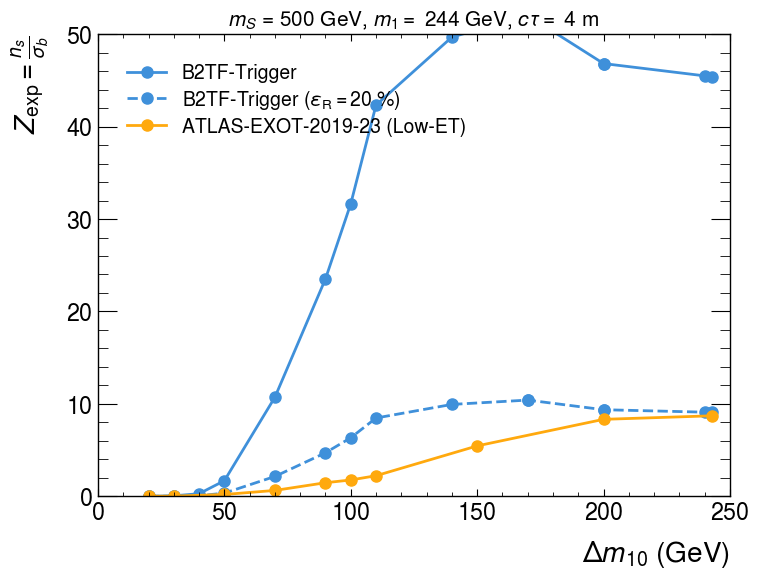

In [8]:
effReco = 0.2
constraints = {'ms' : 500.0, 'ctau' : 4.0}
xaxis = 'dm'
yaxis = 'Z0'


# Filter data
df_filterList = []
for df in [b2tf_data_df,atlas_data_df]:
    df_filter = df.copy()
    for label,val in constraints.items():
        df_filter = df_filter[(np.abs(df_filter[label]-val) < 0.1)]
    df_filter = df_filter.sort_values(xaxis)
    df_filterList.append(df_filter)

b2tf_data_df_filter = df_filterList[0]
atlas_data_df_filter = df_filterList[1]

p = plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis],'o-',label='B2TF-Trigger')
plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis]*effReco,'o--',label=r'B2TF-Trigger ($\epsilon_{\rm R} = %1.0f$ %%)' %(100*effReco),
         c=p[0].get_color())
plt.plot(atlas_data_df_filter[xaxis],atlas_data_df_filter[yaxis],'o-',label='ATLAS-EXOT-2019-23 (Low-ET)')

plt.ylim(0.,50.)
plt.xlabel(r'%s' %varDict[xaxis])
plt.ylabel(r'%s' %varDict[yaxis])
plt.title(getTitleFromDF(b2tf_data_df_filter),fontsize=15)
plt.legend(loc='upper left')
plt.savefig('Z0_vs_dm_ms500_lowET.png')
plt.show()

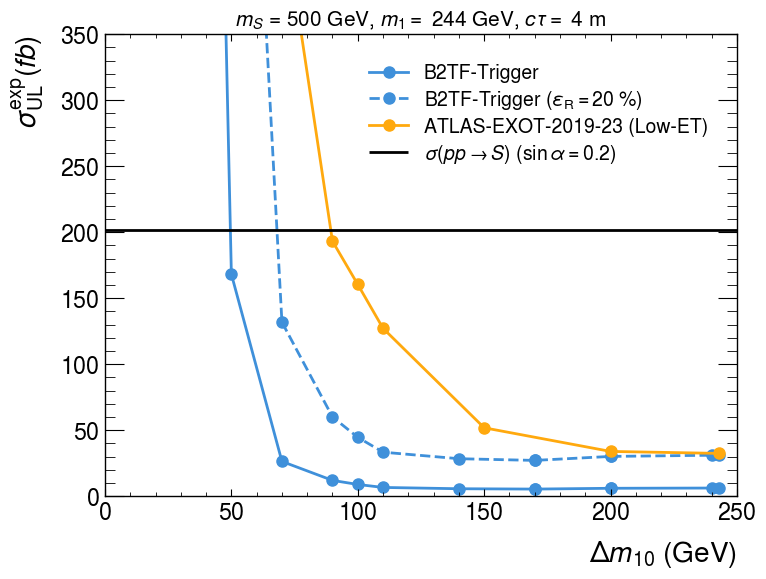

In [9]:

effReco = 0.2
constraints = {'ms' : 500.0, 'ctau' : 4.0}
xaxis = 'dm'
yaxis = 'sigmaUL'


# Filter data
df_filterList = []
for df in [b2tf_data_df,atlas_data_df]:
    df_filter = df.copy()
    for label,val in constraints.items():
        df_filter = df_filter[(np.abs(df_filter[label]-val) < 0.1)]
    df_filter = df_filter.sort_values(xaxis)
    df_filterList.append(df_filter)

b2tf_data_df_filter = df_filterList[0]
atlas_data_df_filter = df_filterList[1]

p = plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis],'o-',label='B2TF-Trigger')
plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis]/effReco,'o--',label=r'B2TF-Trigger ($\epsilon_{\rm R} = %1.0f$ %%)' %(100*effReco),
         c=p[0].get_color())
plt.plot(atlas_data_df_filter[xaxis],atlas_data_df_filter[yaxis],'o-',label='ATLAS-EXOT-2019-23 (Low-ET)')

# Add sigma line
sigmaTheory = b2tf_data_df_filter['xsecfb'].unique()[0]
plt.hlines(y=sigmaTheory,xmin=0.,xmax=250.,label=r'$\sigma( p p \rightarrow S)$ ($\sin\alpha = 0.2$)',linestyles='-',color='black')

# plt.yscale('log')
plt.ylim(0,350.0)

plt.xlabel(r'%s' %varDict[xaxis])
plt.ylabel(r'%s' %varDict[yaxis])
plt.title(getTitleFromDF(b2tf_data_df_filter),fontsize=15)
plt.legend(loc='upper right')
plt.savefig('sigUL_vs_dm_ms500_lowET.png')
plt.show()

### Plot Results: mS = 2000 GeV

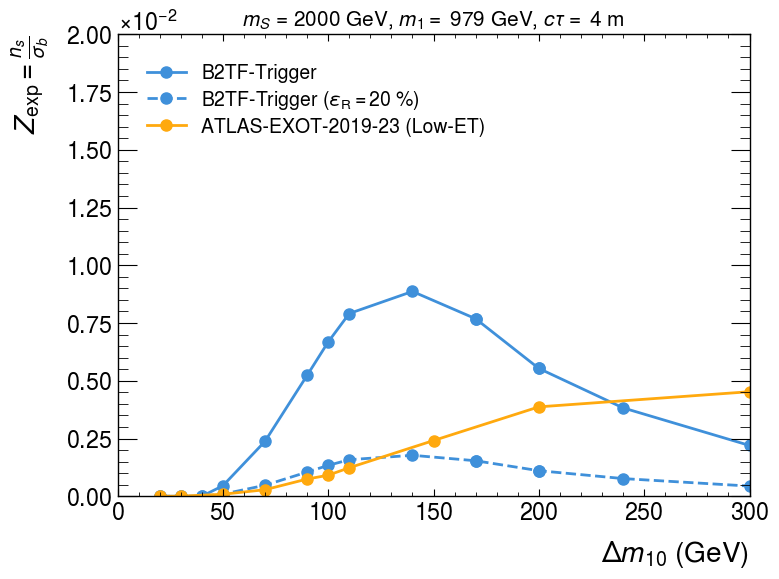

In [10]:
effReco = 0.2
constraints = {'ms' : 2000.0, 'ctau' : 4.0}
xaxis = 'dm'
yaxis = 'Z0'


# Filter data
df_filterList = []
for df in [b2tf_data_df,atlas_data_df]:
    df_filter = df.copy()
    for label,val in constraints.items():
        df_filter = df_filter[(np.abs(df_filter[label]-val) < 0.1)]
    df_filter = df_filter.sort_values(xaxis)
    df_filterList.append(df_filter)

b2tf_data_df_filter = df_filterList[0]
atlas_data_df_filter = df_filterList[1]

p = plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis],'o-',label='B2TF-Trigger')
plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis]*effReco,'o--',label=r'B2TF-Trigger ($\epsilon_{\rm R} = %1.0f$ %%)' %(100*effReco),
         c=p[0].get_color())
plt.plot(atlas_data_df_filter[xaxis],atlas_data_df_filter[yaxis],'o-',label='ATLAS-EXOT-2019-23 (Low-ET)')

plt.ylim(0.,2e-2)
plt.xlabel(r'%s' %varDict[xaxis])
plt.ylabel(r'%s' %varDict[yaxis])
plt.title(getTitleFromDF(b2tf_data_df_filter),fontsize=15)
plt.legend(loc='upper left')
plt.savefig('Z0_vs_dm_ms2000_lowET.png')
plt.show()

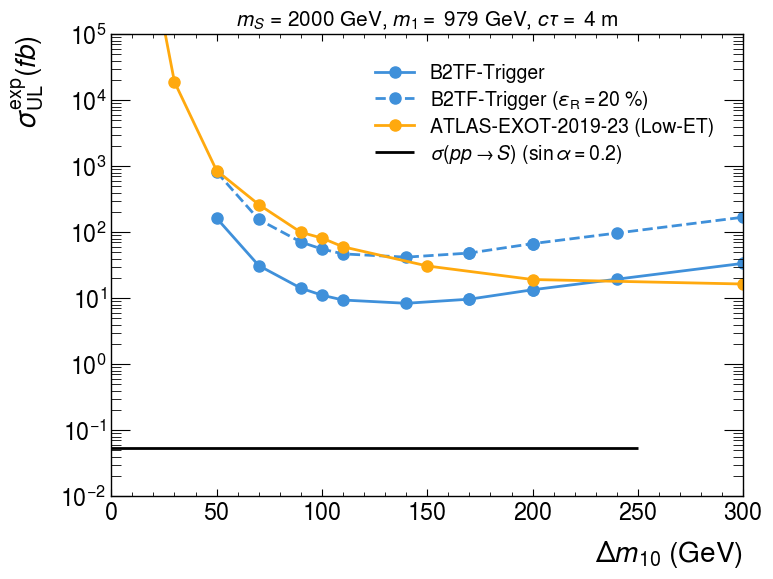

In [11]:

effReco = 0.2
constraints = {'ms' : 2000.0, 'ctau' : 4.0}
xaxis = 'dm'
yaxis = 'sigmaUL'


# Filter data
df_filterList = []
for df in [b2tf_data_df,atlas_data_df]:
    df_filter = df.copy()
    for label,val in constraints.items():
        df_filter = df_filter[(np.abs(df_filter[label]-val) < 0.1)]
    df_filter = df_filter.sort_values(xaxis)
    df_filterList.append(df_filter)

b2tf_data_df_filter = df_filterList[0]
atlas_data_df_filter = df_filterList[1]

p = plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis],'o-',label='B2TF-Trigger')
plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis]/effReco,'o--',label=r'B2TF-Trigger ($\epsilon_{\rm R} = %1.0f$ %%)' %(100*effReco),
         c=p[0].get_color())
plt.plot(atlas_data_df_filter[xaxis],atlas_data_df_filter[yaxis],'o-',label='ATLAS-EXOT-2019-23 (Low-ET)')

# Add sigma line
sigmaTheory = b2tf_data_df_filter['xsecfb'].unique()[0]
plt.hlines(y=sigmaTheory,xmin=0.,xmax=250.,label=r'$\sigma( p p \rightarrow S)$ ($\sin\alpha = 0.2$)',linestyles='-',color='black')

plt.yscale('log')
plt.ylim(1e-2,1e5)

plt.xlabel(r'%s' %varDict[xaxis])
plt.ylabel(r'%s' %varDict[yaxis])
plt.title(getTitleFromDF(b2tf_data_df_filter),fontsize=15)
plt.legend(loc='upper right')
plt.savefig('sigUL_vs_dm_ms2000_lowET.png')
plt.show()

### Plot as a function of mS

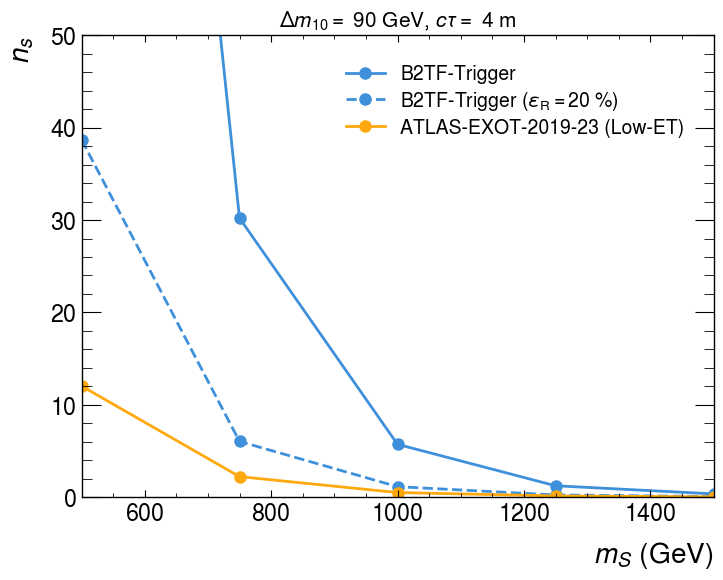

In [12]:
effReco = 0.2
constraints = {'dm' : 90.0, 'ctau' : 4.0}
xaxis = 'ms'
yaxis = 'ns'

# Filter data
df_filterList = []
for df in [b2tf_data_df,atlas_data_df]:
    df_filter = df.copy()
    for label,val in constraints.items():
        df_filter = df_filter[(np.abs(df_filter[label]-val) < 0.1)]
        df_filter[label] = df_filter[label].round(0)
    df_filter = df_filter.sort_values(xaxis)
    df_filterList.append(df_filter)

b2tf_data_df_filter = df_filterList[0]
atlas_data_df_filter = df_filterList[1]

p = plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis],'o-',label='B2TF-Trigger')
plt.plot(b2tf_data_df_filter[xaxis],b2tf_data_df_filter[yaxis]*effReco,'o--',label=r'B2TF-Trigger ($\epsilon_{\rm R} = %1.0f$ %%)' %(100*effReco),
         c=p[0].get_color())
plt.plot(atlas_data_df_filter[xaxis],atlas_data_df_filter[yaxis],'o-',label='ATLAS-EXOT-2019-23 (Low-ET)')


plt.ylim(0.0,50.)
plt.xlim(500.,1500.)
# plt.yscale('log')
plt.xlabel(r'%s' %varDict[xaxis])
plt.ylabel(r'%s' %varDict[yaxis])
plt.title(getTitleFromDF(b2tf_data_df_filter),fontsize=15)
plt.legend(loc='upper right')
plt.savefig('Ns_vs_ms_lowET.png')
plt.show()